In [1]:
# packages to load 
# Check the versions of libraries
# Python version
import warnings
warnings.filterwarnings('ignore')
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
import numpy
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# numpy
import numpy as np # linear algebra
print('numpy: {}'.format(np.__version__))
# pandas
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print('pandas: {}'.format(pd.__version__))
import seaborn as sns
print('seaborn: {}'.format(sns.__version__))
sns.set(color_codes=True)
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))
%matplotlib inline
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
%matplotlib inline
from sklearn.metrics import accuracy_score
# Importing metrics for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy import stats
from scipy.stats import norm, skew #for some statistics

Python: 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 18:50:55) [MSC v.1915 64 bit (AMD64)]
scipy: 1.2.0
matplotlib: 3.0.2
numpy: 1.15.4
pandas: 0.24.1
seaborn: 0.9.0
matplotlib: 3.0.2
sklearn: 0.20.2


In [2]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [3]:
from subprocess import check_output

In [4]:
# import Dataset to play with it
#train = pd.read_csv('/Users/ghostdev/Desktop/REML/train.csv')
#test= pd.read_csv('/Users/ghostdev/Desktop/REML/test.csv')
# import Dataset to play with it
listings_df = pd.read_csv('listings.csv',encoding='utf-8')
calendar_df = pd.read_csv('calendar.csv',encoding='utf-8')

In [5]:
#Veri temizle için yardımcı fonksiyon
def get_month_from_date(row):
    ''' Ay bulma '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Yıl bulma '''
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    ''' konaklama yılını bulma '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Kukla sütunları doldurma '''
    val = 0.0
    try:
        vals = row[column_name].replace('[',
                                        '').replace("'", '').replace("]", '').replace('"',
                                        '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' sütunda bulunan değerleri liste haline getirme örneğin: amenities/kolaylıklar '''
    
    # versetindeki tekil değerleri getirme
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'",
                                                           '').replace("]", '').replace('"', '').replace('{',
                                                            '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
     # sütunlara ayırma
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

def get_extra_people_fee(row):
    ''' fazladan bir kişi geldiğinde sonuç olarak 1 döndürecek '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

#Veri temizleme fonksiyonu
def clean_dataset(listings_df, calendar_df):
    '''
    Girişler
    listings_df - pandas dataframe ilan veri seti 
    calendar_df - pandas dataframe rezervasyon veri seti
    
    Çıktılar
    df - temizlenmiş veri seti, ilan ve rezervasyon veri setlerinin birleştirilmesiyle oluşturulmuştur:
    1. İlişkisiz sütunlar veri setinden kaldırılmıştır;
    2. Tarih verileri ay ve yıl bildirecek şekilde sayısayl hale getirilmiştir.;
    3. içerisinde liste barından sütunlar tekrar sütunlara ayırlarak veri normalizasyonu yapılmıştır.
    4. missing values are imputed with mean or mode.
    '''
    #veri setini birleştirme
    calendar_df = calendar_df.rename(index=str, columns={"listing_id": "id"})
    df = pd.merge(calendar_df, listings_df, on = 'id')
    
    #ilişkisiz  sütunlarını kaldırma
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
               'host_total_listings_count', 'weekly_price', 'monthly_price',
               'security_deposit', 'cleaning_fee', 'calendar_updated',
               'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
               'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
               'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
               'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
               'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
               'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
               'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
               'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
               'reviews_per_month','host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified',
               'neighbourhood_group_cleansed','property_type','room_type','bed_type','instant_bookable','cancellation_policy',
               'require_guest_profile_picture','require_guest_phone_verification']
    df = df.drop(columns = columns_to_drop)
    
    #rezervasyon veri setinde tarih olarak gelen sütun değerini gün,ay ve yıl olarak üçe bölerek sayısallaştırma
    df['month'] = df.apply(lambda row: get_month_from_date(row),axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row),axis=1)
    df['day'] = df.apply(lambda row: get_day_from_date(row),axis=1)
    df = df.drop(columns = ['date'])
    
    #price_x sütununu kaldırma süreci
    df = df.dropna(subset=['price_x'])
    
    #fiyat sütununu sayısallaştıma
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])
    
    #host_since tarih alanındaki tarihi sayısallaştırma ve boş verileri kaldırma işlemi
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
    df = df.drop(columns = ['host_since'])
    
    #host_response_rate sütunundaki verileri sayısallaştırma ve boş verileri kaldırma işlemi
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)
    
    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    
    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
    # host_listings_count sütunundaki boş verileri ortalama host_listings_count ile doldurma
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)
    
    #host_verifications kukla sütunun bölünlendirme ve orjinal değerleri kaldırma işlemi
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])
    
    #bathrooms, bedrooms and beds sütunların mode alarak boş verileri doldurma işlemi
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    
    #amenities, kukla değişkenlere bölerek orjinal halindeki veriyi silme işlemi
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])
    
    #fazladan kişi olması durumunda sonucun 1 olmaması durumunda sonucun 0 olarak ayarlanma işlemi
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)
    df = df.drop(columns = ['extra_people'])
    
    #kullanıcıların görüşlerinin verilerinin tutulduğu sütunlardaki boş verilerin doldurulma işlemi
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df

In [7]:
# oluştulmuş veri temizle fonksiyonun çağırma ve veriyi temizleyip birleştirme işleminin yapılması
df = clean_dataset(listings_df, calendar_df)

In [9]:
df_copy = df.copy()
train_set = df_copy.sample(frac=0.5, random_state=0)
test_set = df_copy.drop(train_set.index)

train = train_set.head(1460)
test = test_set.head(1459)

In [10]:
type(train)

pandas.core.frame.DataFrame

In [11]:
type(test)

pandas.core.frame.DataFrame

In [12]:
# shape
print(train.shape)

(1460, 45)


In [13]:
# shape
print(test.shape)

(1459, 45)


In [14]:
#columns*rows
train.size

65700

In [15]:
#columns*rows
test.size

65655

In [16]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 940747 to 1012416
Data columns (total 45 columns):
id                                    1460 non-null int64
host_listings_count                   1460 non-null float64
accommodates                          1460 non-null int64
bathrooms                             1460 non-null float64
bedrooms                              1460 non-null float64
beds                                  1460 non-null float64
guests_included                       1460 non-null int64
minimum_nights                        1460 non-null int64
maximum_nights                        1460 non-null int64
number_of_reviews                     1460 non-null int64
review_scores_rating                  1460 non-null float64
review_scores_accuracy                1460 non-null float64
review_scores_cleanliness             1460 non-null float64
review_scores_checkin                 1460 non-null float64
review_scores_communication           1460 non-null float

In [17]:
train.head(5) 

,id,host_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,number_of_reviews,...,amenities_Heating,amenities_Kitchen,amenities_Smoke Detector,amenities_Essentials,amenities_Dryer,amenities_Washer,amenities_Internet,amenities_Shampoo,amenities_TV,extra_people_fee
940747,3858725,1.000,2,1.000,1.000,1.000,1,1,1125,12,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
581112,9460,2.000,2,1.000,1.000,1.000,1,3,29,240,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
66041,3052151,2.000,2,1.000,1.000,1.000,1,2,14,19,...,1.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000
345823,3123632,1.000,2,2.000,1.000,1.000,2,5,1125,8,...,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000
640729,6412566,6.000,3,1.000,1.000,2.000,1,1,1125,17,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000


In [18]:
train.tail(5) 

,id,host_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,number_of_reviews,...,amenities_Heating,amenities_Kitchen,amenities_Smoke Detector,amenities_Essentials,amenities_Dryer,amenities_Washer,amenities_Internet,amenities_Shampoo,amenities_TV,extra_people_fee
1045002,1348777,3.000,2,1.000,1.000,1.000,1,1,90,14,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
21464,4566393,1.000,4,2.500,3.000,3.000,4,2,1125,0,...,1.000,1.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000
1168672,7921289,1.000,2,1.000,1.000,1.000,1,2,1125,1,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000
132735,1252740,1.000,2,1.500,1.000,1.000,2,2,14,66,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1012416,4231670,1.000,3,1.000,2.000,1.000,1,3,1125,4,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000


In [19]:
train.sample(5) 

,id,host_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,number_of_reviews,...,amenities_Heating,amenities_Kitchen,amenities_Smoke Detector,amenities_Essentials,amenities_Dryer,amenities_Washer,amenities_Internet,amenities_Shampoo,amenities_TV,extra_people_fee
438394,1831338,2.000,2,1.000,1.000,1.000,2,1,1125,17,...,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000
796491,6546748,2.000,6,3.000,3.000,3.000,6,2,1125,7,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
633608,353347,1.000,8,1.000,2.000,3.000,4,5,14,29,...,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000
959665,8779676,2.000,2,1.000,1.000,1.000,1,2,1125,6,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1096992,4127196,1.000,3,1.000,1.000,2.000,2,3,1125,4,...,1.000,0.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000


In [20]:
train.describe() 

,id,host_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,number_of_reviews,...,amenities_Heating,amenities_Kitchen,amenities_Smoke Detector,amenities_Essentials,amenities_Dryer,amenities_Washer,amenities_Internet,amenities_Shampoo,amenities_TV,extra_people_fee
count,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,5273578.529,8.386,3.208,1.229,1.253,1.708,1.597,2.056,858.231,24.460,...,0.947,0.888,0.830,0.817,0.773,0.776,0.722,0.674,0.649,0.464
std,3020527.013,28.314,1.857,0.545,0.791,1.110,1.183,2.164,2641.463,40.926,...,0.224,0.315,0.376,0.387,0.419,0.417,0.448,0.469,0.478,0.499
min,4291.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2746534.000,1.000,2.000,1.000,1.000,1.000,1.000,1.000,120.000,2.000,...,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000
50%,5446176.000,1.000,2.000,1.000,1.000,1.000,1.000,2.000,1125.000,10.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000
75%,7873037.000,3.000,4.000,1.000,1.000,2.000,2.000,2.000,1125.000,28.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
max,10339145.000,354.000,16.000,8.000,5.000,10.000,12.000,31.000,100000.000,474.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [21]:
train.isnull().sum()

id                                    0
host_listings_count                   0
accommodates                          0
bathrooms                             0
bedrooms                              0
beds                                  0
guests_included                       0
minimum_nights                        0
maximum_nights                        0
number_of_reviews                     0
review_scores_rating                  0
review_scores_accuracy                0
review_scores_cleanliness             0
review_scores_checkin                 0
review_scores_communication           0
review_scores_location                0
review_scores_value                   0
calculated_host_listings_count        0
month                                 0
year                                  0
day                                   0
price                                 0
host_since_year                       0
host_response_rate_buckets            0
host_verifications_email              0


In [22]:
train.columns

Index(['id', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'guests_included', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count', 'month',
       'year', 'day', 'price', 'host_since_year', 'host_response_rate_buckets',
       'host_verifications_email', 'host_verifications_ phone',
       'host_verifications_ reviews', 'host_verifications_ facebook',
       'host_verifications_ jumio', 'host_verifications_ kba',
       'host_verifications_ linkedin', 'host_verifications_ google',
       'host_verifications_ manual_offline', 'host_verifications_phone',
       'amenities_Wireless Internet', 'amenities_Heating', 'amenities_Kitchen',
       'amenities_Smoke Detector', 'amenities_Essentials', 'amenities_Dryer',


In [26]:
numberic_features=train.select_dtypes(include=[np.number])
categorical_features=train.select_dtypes(include=[np.object])

In [27]:
train['price'].describe()

count   1460.000
mean     135.314
std      101.294
min       20.000
25%       75.000
50%      109.000
75%      159.000
max     1240.000
Name: price, dtype: float64

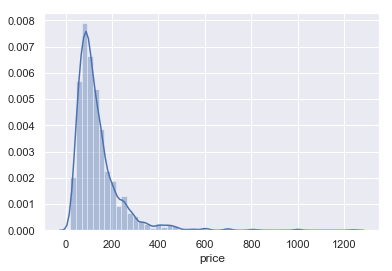

In [28]:
sns.distplot(train['price']);

In [29]:
#skewness and kurtosis
print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

Skewness: 3.603828
Kurtosis: 22.744624


C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


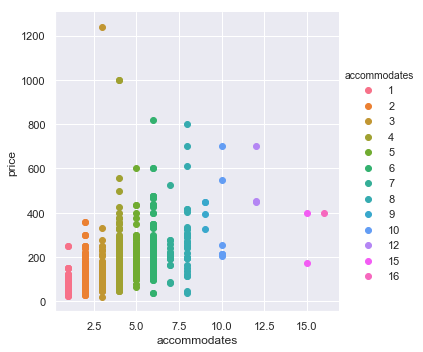

In [31]:
# Modify the graph above by assigning each species an individual color.
columns = ['price','accommodates','bathrooms', 'host_listings_count', 'year','minimum_nights','review_scores_rating','number_of_reviews']
sns.FacetGrid(train[columns], hue="accommodates", size=5) \
   .map(plt.scatter, "accommodates", "price") \
   .add_legend()
plt.show()

<Figure size 432x288 with 0 Axes>

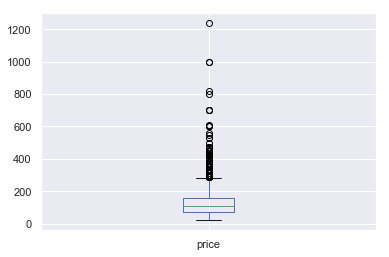

<Figure size 432x288 with 0 Axes>

In [32]:
train[columns].plot(y='price',x='accommodates',kind='box')
plt.figure()
#This gives us a much clearer idea of the distribution of the input attributes:

<Figure size 432x288 with 0 Axes>

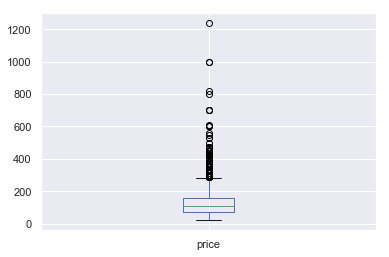

<Figure size 432x288 with 0 Axes>

In [33]:
train[columns].plot(y='price',x='accommodates',kind='box')
plt.figure()
#This gives us a much clearer idea of the distribution of the input attributes:

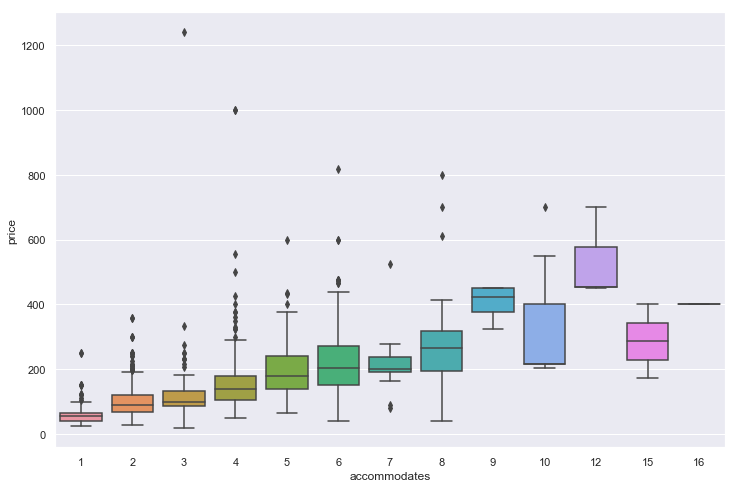

In [34]:
data = pd.concat([train['price'], train['accommodates']], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x='accommodates', y="price", data=data)

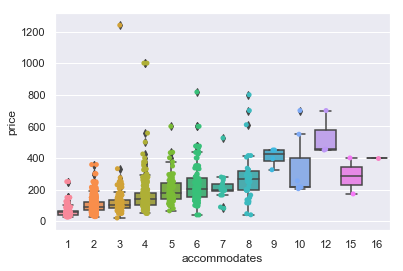

In [35]:
# Use Seaborn's striplot to add data points on top of the box plot 
# Insert jitter=True so that the data points remain scattered and not piled into a verticle line.
# Assign ax to each axis, so that each plot is ontop of the previous axis. 

ax= sns.boxplot(x="accommodates", y="price", data=train[columns])
ax= sns.stripplot(x="accommodates", y="price", data=train[columns], jitter=True, edgecolor="gray")
plt.show()

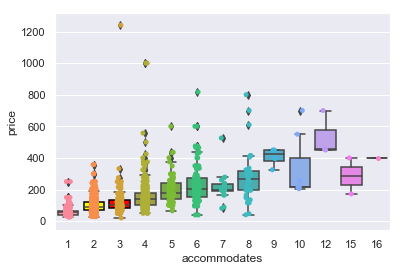

In [36]:
# Tweek the plot above to change fill and border color color using ax.artists.
# Assing ax.artists a variable name, and insert the box number into the corresponding brackets

ax= sns.boxplot(x="accommodates", y="price", data=train[columns])
ax= sns.stripplot(x="accommodates", y="price", data=train[columns], jitter=True, edgecolor="gray")

boxtwo = ax.artists[2]
boxtwo.set_facecolor('red')
boxtwo.set_edgecolor('black')
boxthree=ax.artists[1]
boxthree.set_facecolor('yellow')
boxthree.set_edgecolor('black')

plt.show()

<Figure size 432x288 with 0 Axes>

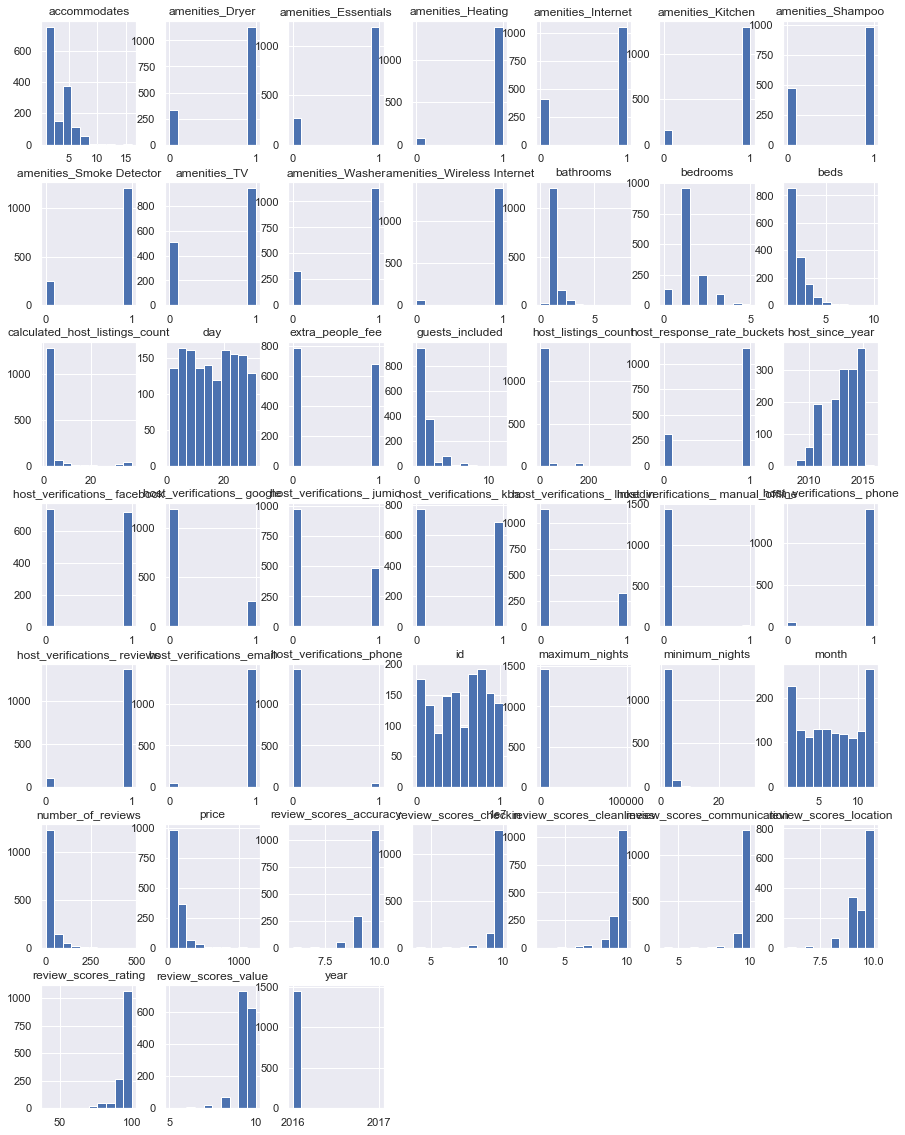

<Figure size 432x288 with 0 Axes>

In [37]:
# histograms
train.hist(figsize=(15,20))
plt.figure()

<Figure size 432x288 with 0 Axes>

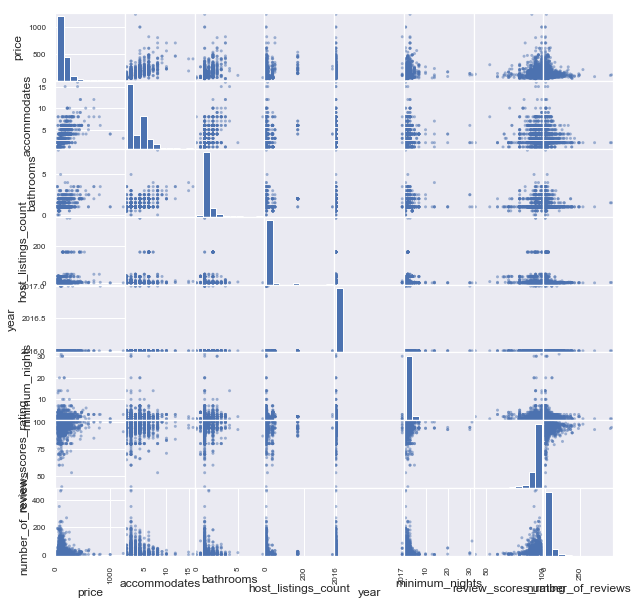

<Figure size 432x288 with 0 Axes>

In [38]:
# scatter plot matrix
pd.plotting.scatter_matrix(train[columns],figsize=(10,10))
plt.figure()

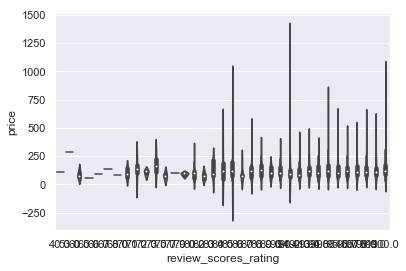

In [39]:
# violinplots on petal-length for each species
sns.violinplot(data=train,x="review_scores_rating", y="price")

C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


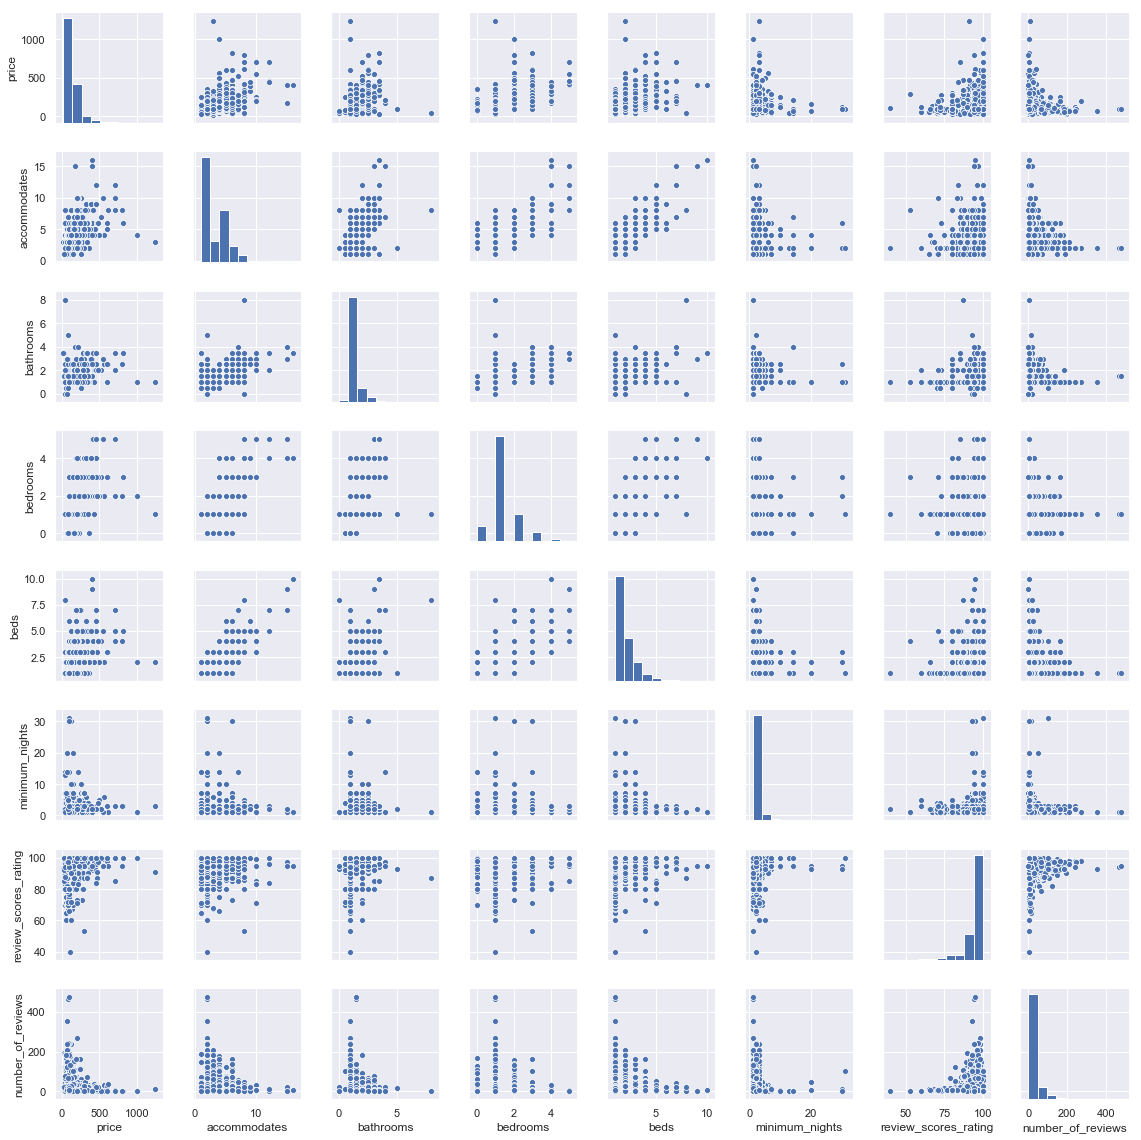

In [40]:
# Using seaborn pairplot to see the bivariate relation between each pair of features
sns.set()
columns = ['price','accommodates','bathrooms', 'bedrooms', 'beds','minimum_nights','review_scores_rating','number_of_reviews']
sns.pairplot(train[columns],size = 2 ,kind ='scatter')
plt.show()

C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


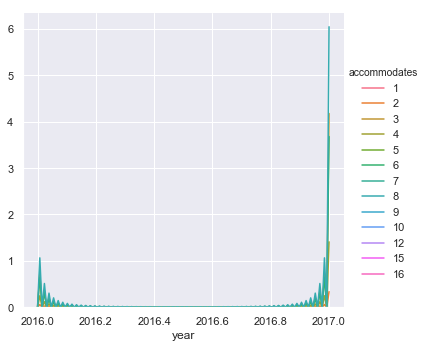

In [41]:
# seaborn's kdeplot, plots univariate or bivariate density estimates.
#Size can be changed by tweeking the value used
columns = ['price','accommodates','bathrooms', 'host_listings_count', 'year','minimum_nights','review_scores_rating','number_of_reviews']
sns.FacetGrid(train[columns], hue="accommodates", size=5).map(sns.kdeplot, "year").add_legend()
plt.show()

C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


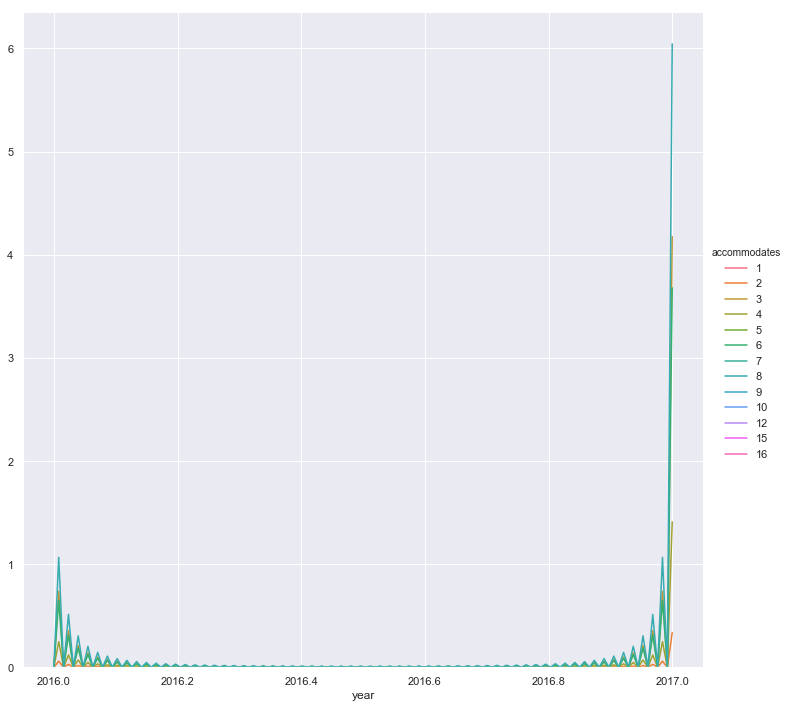

In [42]:
# seaborn's kdeplot, plots univariate or bivariate density estimates.
#Size can be changed by tweeking the value used
columns = ['price','accommodates','bathrooms', 'host_listings_count', 'year','minimum_nights','review_scores_rating','number_of_reviews']
sns.FacetGrid(train[columns], hue="accommodates", size=10).map(sns.kdeplot, "year").add_legend()
plt.show()

C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


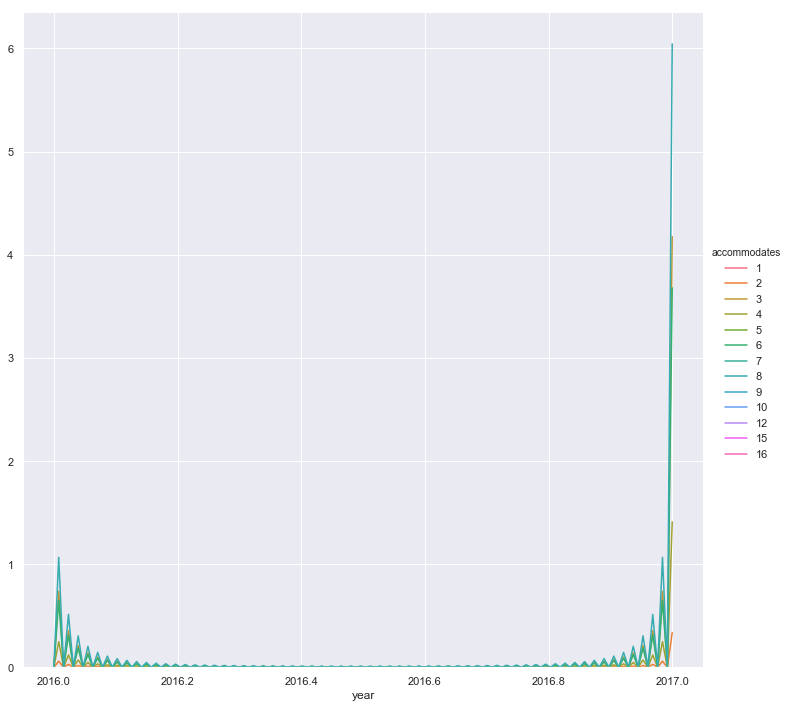

In [43]:
# seaborn's kdeplot, plots univariate or bivariate density estimates.
#Size can be changed by tweeking the value used
columns = ['price','accommodates','bathrooms', 'host_listings_count', 'year','minimum_nights','review_scores_rating','number_of_reviews']
sns.FacetGrid(train[columns], hue="accommodates", size=10).map(sns.kdeplot, "year").add_legend()
plt.show()

C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


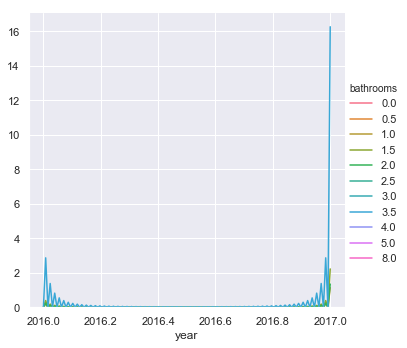

In [44]:
# seaborn's kdeplot, plots univariate or bivariate density estimates.
#Size can be changed by tweeking the value used
columns = ['price','accommodates','bathrooms', 'host_listings_count', 'year','minimum_nights','review_scores_rating','number_of_reviews']
sns.FacetGrid(train[columns], hue="bathrooms", size=5).map(sns.kdeplot, "year").add_legend()
plt.show()

C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


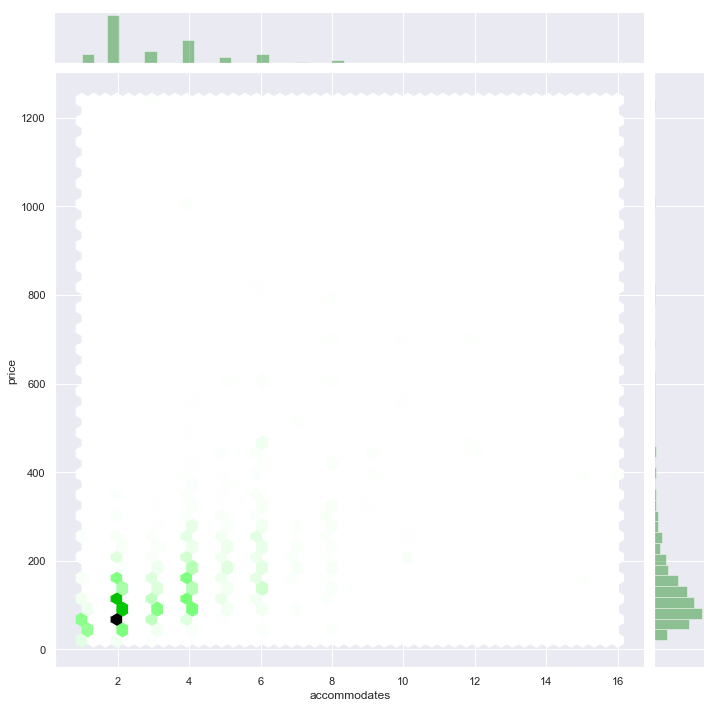

In [45]:
# Use seaborn's jointplot to make a hexagonal bin plot
#Set desired size and ratio and choose a color.
columns = ['price','accommodates','bathrooms', 'host_listings_count', 'year','minimum_nights','review_scores_rating','number_of_reviews']
sns.jointplot(x="accommodates", y="price", data=train[columns], size=10,ratio=10, kind='hex',color='green')
plt.show()

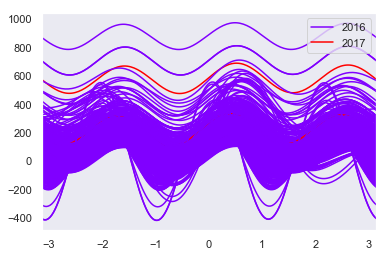

In [46]:
#In Pandas use Andrews Curves to plot and visualize data structure.
#Each multivariate observation is transformed into a curve and represents the coefficients of a Fourier series.
#This useful for detecting outliers in times series data.
#Use colormap to change the color of the curves
columns = ['price','accommodates','bathrooms', 'host_listings_count', 'year','minimum_nights','review_scores_rating','number_of_reviews']
from pandas.plotting import andrews_curves
andrews_curves(train[columns], "year",colormap='rainbow')
plt.show()

C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\matplotlib\contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\matplotlib\contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


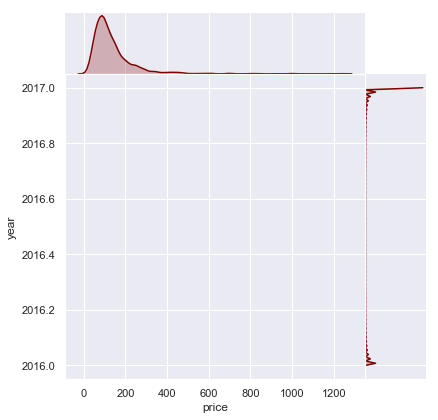

In [47]:
# we will use seaborn jointplot shows bivariate scatterplots and univariate histograms with Kernel density 
# estimation in the same figure
columns = ['price','accommodates','bathrooms', 'host_listings_count', 'year','minimum_nights','review_scores_rating','number_of_reviews']
sns.jointplot(x="price", y="year", data=train[columns], size=6, kind='kde', color='#800000', space=0)

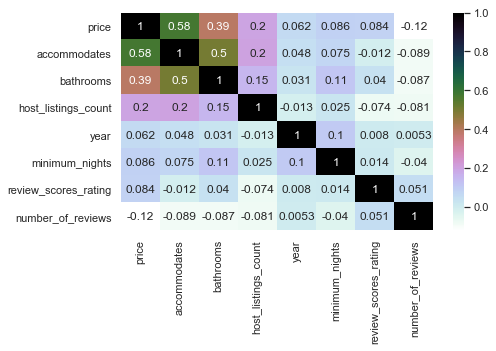

In [48]:
plt.figure(figsize=(7,4)) 
columns = ['price','accommodates','bathrooms', 'host_listings_count', 'year','minimum_nights','review_scores_rating','number_of_reviews']
sns.heatmap(train[columns].corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlation matrix calculted by(iris.corr())
plt.show()

In [49]:
# Save Id and drop it
train_ID=train['id']
test_ID=test['id']
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

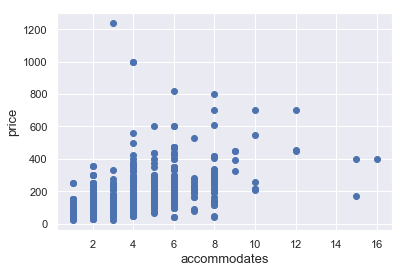

In [50]:
fig, ax = plt.subplots()
ax.scatter(x = train['accommodates'], y = train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('accommodates', fontsize=13)
plt.show()

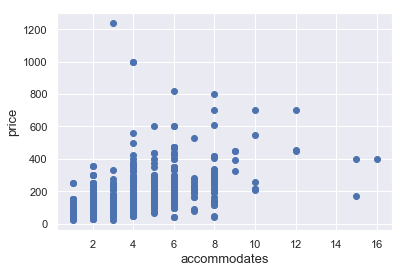

In [51]:
#Deleting outliers
train = train.drop(train[(train['accommodates']>8) & (train['price']> 800)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['accommodates'], train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('accommodates', fontsize=13)
plt.show()


 mu = 135.31 and sigma = 101.26



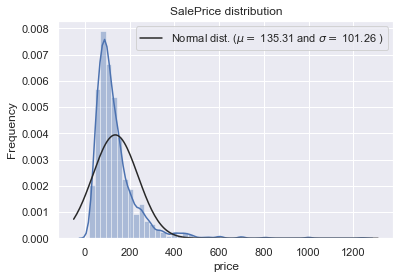

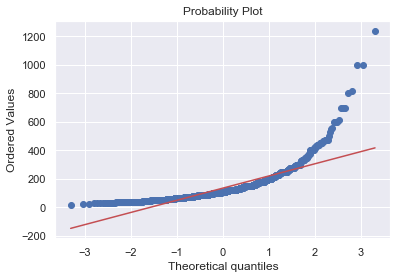

In [52]:
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()


 mu = 4.73 and sigma = 0.58



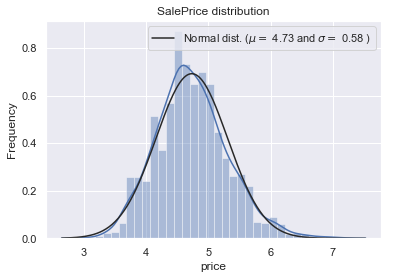

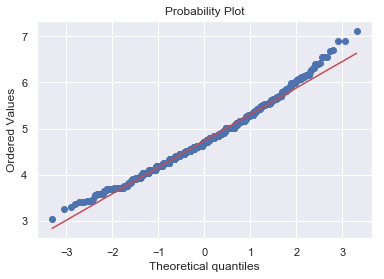

In [53]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["price"] = np.log1p(train["price"])

#Check the new distribution 
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

In [54]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.price.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['price'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 43)


In [55]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


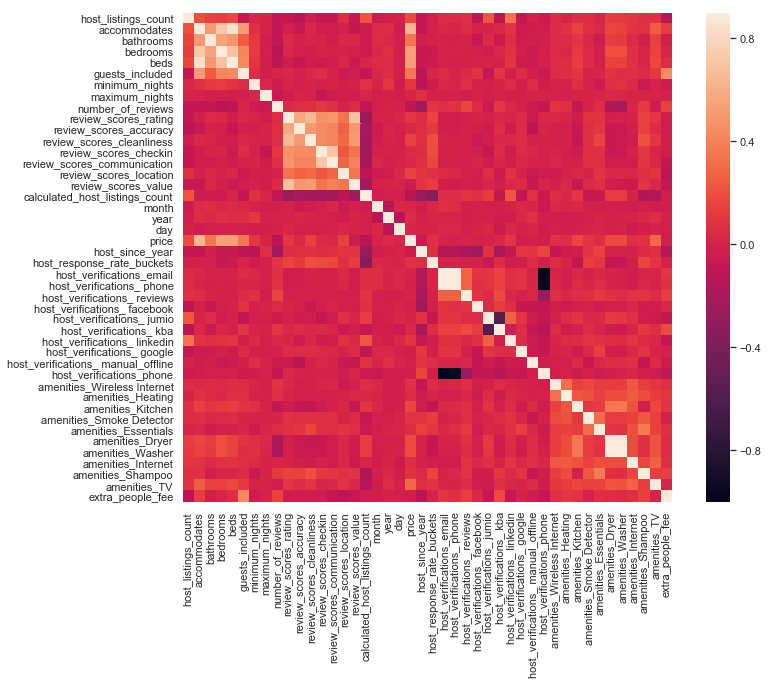

In [57]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [58]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [61]:
#MSSubClass=The building class
all_data['minimum_nights'] = all_data['minimum_nights'].apply(str)


#Changing OverallCond into a categorical variable
all_data['accommodates'] = all_data['accommodates'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['year'] = all_data['year'].astype(str)
all_data['month'] = all_data['month'].astype(str)

In [65]:
from sklearn.preprocessing import LabelEncoder
cols = ('review_scores_rating', 'number_of_reviews', 'host_listings_count', 'bathrooms',  
        'minimum_nights','guests_included', 'maximum_nights', 'host_since_year', 'bedrooms', 
        'beds', 'calculated_host_listings_count', 'review_scores_location', 'review_scores_value', 
        'accommodates','year', 'month')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 43)


In [66]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
host_verifications_ manual_offline,12.616
year,12.273
host_verifications_phone,7.776
calculated_host_listings_count,3.045
host_listings_count,3.005
bathrooms,2.949
beds,2.488
guests_included,2.443
host_verifications_ google,2.002
bedrooms,1.902


In [67]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 43 skewed numerical features to Box Cox transform


In [68]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 43)


In [69]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [70]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
import xgboost as xgb
import lightgbm as lgb

In [71]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [72]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [73]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [74]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [75]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [76]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [77]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [78]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4004 (0.0158)



In [79]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.4006 (0.0157)



In [80]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.3863 (0.0166)



In [81]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.3588 (0.0200)



In [82]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.3548 (0.0231)



In [83]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.3609 (0.0207)



In [84]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [85]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.3729 (0.0166)



In [86]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [87]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.3582 (0.0190)


In [88]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [89]:
#StackedRegressor
#Final Training and Prediction
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.21313776366405277


In [90]:
#XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.1713571970597947


In [91]:
#lightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.28441250276266383


In [92]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.21348957174720665


In [93]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [94]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Price'] = ensemble
sub.to_csv('submission.csv',index=False)